In [20]:
#********************************* Part 1: Data Preprocessing *******************************************************************************
# Uploading the dataset
from google.colab import files
uploaded = files.upload()


Saving Dry_Bean_Dataset.xlsx to Dry_Bean_Dataset (1).xlsx


In [21]:
#Importing Libraries & Loading the Dataset
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_excel("Dry_Bean_Dataset.xlsx")

# Preview the dataset
df.head()


,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


In [22]:
# Adding Missing Values
# Adding 5% missing values to 'Area' and 'Perimeter'
for col in ['Area', 'Perimeter']:
    df.loc[df.sample(frac=0.05, random_state=42).index, col] = np.nan

# Adding 35% missing values to 'Eccentricity'
df.loc[df.sample(frac=0.35, random_state=1).index, 'Eccentricity'] = np.nan

# Saving the dataset with missing values to a new CSV file
df.to_csv("Dry_Bean_Missing_Example.csv", index=False)


In [23]:
# Observing missing values by checking how many missing values per column
df.isnull().sum()


,0
Area,681
Perimeter,681
MajorAxisLength,0
MinorAxisLength,0
AspectRation,0
Eccentricity,4764
ConvexArea,0
EquivDiameter,0
Extent,0
Solidity,0


In [24]:
# Filling 5% missing in 'Area' and 'Perimeter' with mean or median
df['Area'] = df['Area'].fillna(df['Area'].median())
df['Perimeter'] = df['Perimeter'].fillna(df['Perimeter'].median())

# For 'Eccentricity' (35% missing), let's drop the column
if 'Eccentricity' in df.columns:
    df.drop(columns=['Eccentricity'], inplace=True)
print(df.columns) # printing all columns to make sure if Eccentricity column is dropped


Index(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'ConvexArea', 'EquivDiameter', 'Extent', 'Solidity',
       'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
       'ShapeFactor3', 'ShapeFactor4', 'Class'],
      dtype='object')


In [25]:
# Outlier Detection (IQR Method )
# Detecting and optionally treating outliers using IQR method
def treat_outliers_iqr(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Capping the outliers
    dataframe[column] = np.where(dataframe[column] < lower_bound, lower_bound,
                          np.where(dataframe[column] > upper_bound, upper_bound, dataframe[column]))
    return dataframe

# Applying to numeric columns except the class label
for col in df.select_dtypes(include=[np.number]).columns:
    df = treat_outliers_iqr(df, col)


In [26]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Separating features and label
X = df.drop(columns=['Class'])  # Features
y = df['Class']                 # Label

# Applying StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Converting back to DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)


In [27]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Now 'Class' is numeric


Explained variance ratios:
 [5.94120958e-01 2.30668381e-01 7.10596684e-02 5.38131052e-02
 3.01897633e-02 7.11579589e-03 6.22400747e-03 2.93454241e-03
 1.85131850e-03 1.57601026e-03 2.61629566e-04 9.58260454e-05
 6.97590662e-05 1.01994843e-05 9.03475502e-06]

Average explained variance: 0.06666666666666667

Number of components > average variance: 3


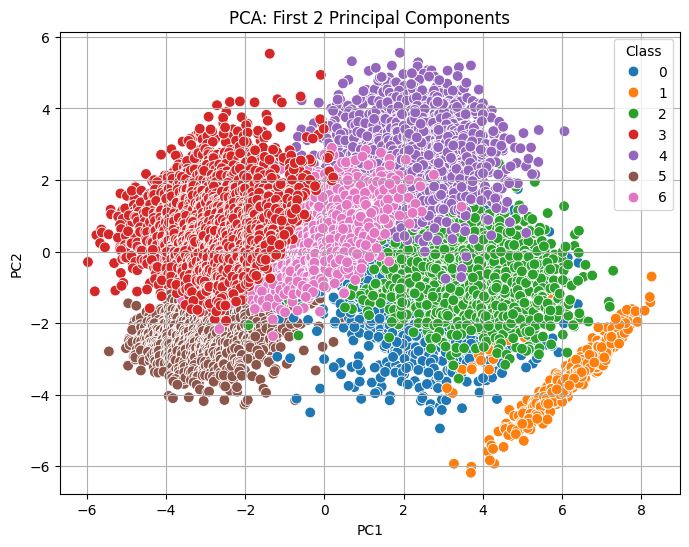

In [28]:
#********************************* Part 2: Feature Selection and Dimensionality Reduction ******************************************************

# PCA (Principal Component Analysis)

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Fitting PCA on the scaled data
pca = PCA()
X_pca = pca.fit_transform(X_scaled_df)

# Explained variance ratios
explained_variance = pca.explained_variance_ratio_
print("Explained variance ratios:\n", explained_variance)

# Average variance threshold
avg_variance = explained_variance.mean()
print("\nAverage explained variance:", avg_variance)

# Find how many components explain above-average variance
above_avg_components = sum(explained_variance > avg_variance)
print("\nNumber of components > average variance:", above_avg_components)

# Visualize the first two PCA components
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_encoded, palette="tab10", s=60)
plt.title('PCA: First 2 Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title="Class")
plt.grid(True)
plt.show()


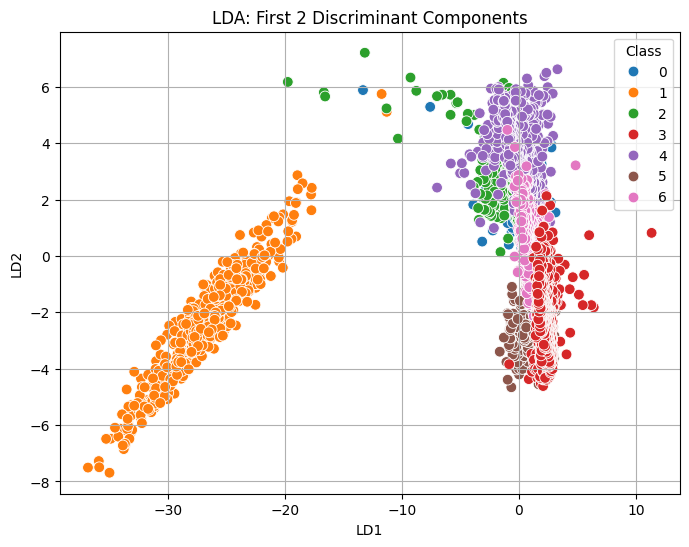

In [29]:
# LDA ( Linear Discriminant Analysis )
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
# Fitting LDA (requires labels)
lda = LDA(n_components=3)
X_lda = lda.fit_transform(X_scaled_df, y_encoded)

# Visualize 2D LDA (first two components)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_lda[:, 0], y=X_lda[:, 1], hue=y_encoded, palette="tab10", s=60)
plt.title('LDA: First 2 Discriminant Components')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend(title="Class")
plt.grid(True)
plt.show()


In [32]:
# ********************************* Part 3: Modeling and Evaluation *****************************************************************
# Implementing Nested Cross-Validation
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Clean results function
def clean_results(results):
    cleaned = {}
    for metric, (mean_val, std_val) in results.items():
        cleaned[metric] = f"{mean_val:.4f} ± {std_val:.4f}"
    return cleaned

def nested_cv(X, y, model, param_grid, outer_splits=5, inner_splits=3, random_seed=42, return_best_model=False):
    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=random_seed)

    #lists to store results for each metric from the 5 outer loops
    accuracies, precisions, recalls, f1_scores = [], [], [], []
    best_fold_model = None
    best_fold_accuracy = 0

    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
        print(f"\n🔁 Outer Fold {fold+1}")

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Instantiate inner_cv inside loop to ensure consistent random_state across outer folds
        inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=random_seed)

        # If there is a hyperparameter grid, perform GridSearchCV
        if param_grid:
            grid_search = GridSearchCV(model, param_grid, cv=inner_cv, scoring='accuracy', n_jobs=-1)
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
        else:
            # No hyperparameter tuning
            best_model = model.fit(X_train, y_train)

        y_pred = best_model.predict(X_test)

        # Store performance after each fold
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)
        precisions.append(precision_score(y_test, y_pred, average='weighted', zero_division=0))
        recalls.append(recall_score(y_test, y_pred, average='weighted'))
        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

        if return_best_model and acc > best_fold_accuracy:
            best_fold_accuracy = acc
            best_fold_model = (best_model, X_test, y_test)

    results = {
        'accuracy': (np.mean(accuracies), np.std(accuracies)),
        'precision': (np.mean(precisions), np.std(precisions)),
        'recall': (np.mean(recalls), np.std(recalls)),
        'f1': (np.mean(f1_scores), np.std(f1_scores))
    }
    if return_best_model:
        return results, best_fold_model
    else:
        return results



In [34]:
# ===================================
# Models and hyperparameters setup
# ===================================
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier


models = {
    'Logistic Regression': (LogisticRegression(max_iter=1000), {
        'C': [0.01, 0.1, 1, 10],
        'solver': ['liblinear', 'lbfgs'],
        'penalty': ['l2']
    }),
    'Decision Tree': (DecisionTreeClassifier(random_state=42), {
        'criterion': ['gini', 'entropy'],
        'max_depth': [3, 5, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }),
    'Random Forest': (RandomForestClassifier(random_state=42), {
        'n_estimators': [100],
        'max_depth': [None, 10],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'bootstrap': [True]
    }),
    'XGBoost': (XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42), {
        'n_estimators': [50, 100],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0]
    }),
    'Naive Bayes': (GaussianNB(), {})  # No hyperparameters to tune
}

# ===================================
# Dataset variations setup
# ===================================
datasets = {
    'RAW': (X_scaled_df.values, y_encoded),
    'PCA': (X_pca, y_encoded),
    'LDA': (X_lda, y_encoded)
}

# ===================================
# Running nested CV for each model and each dataset
# ===================================
overall_results = {}

for model_name, (model_instance, param_grid) in models.items():
    print(f"\n\n================ {model_name} ================\n")
    model_results = {}

    for data_name, (X_data, y_data) in datasets.items():
        print(f"📂 {model_name} on {data_name} Data")


        result = nested_cv(X_data, y_data, model_instance, param_grid)
        model_results[data_name] = clean_results(result)

    overall_results[model_name] = model_results

# ===================================
# Displaying Final Summaries
# ===================================
for model_name, results in overall_results.items():
    print(f"\n📊 {model_name} Results Summary")
    for data_name, metrics in results.items():
        print(f"{data_name}: {metrics}")



================ Logistic Regression ================

📂 Logistic Regression on RAW Data

🔁 Outer Fold 1

🔁 Outer Fold 2

🔁 Outer Fold 3

🔁 Outer Fold 4

🔁 Outer Fold 5
📂 Logistic Regression on PCA Data

🔁 Outer Fold 1

🔁 Outer Fold 2

🔁 Outer Fold 3

🔁 Outer Fold 4

🔁 Outer Fold 5
📂 Logistic Regression on LDA Data

🔁 Outer Fold 1

🔁 Outer Fold 2

🔁 Outer Fold 3

🔁 Outer Fold 4

🔁 Outer Fold 5


================ Decision Tree ================

📂 Decision Tree on RAW Data

🔁 Outer Fold 1

🔁 Outer Fold 2

🔁 Outer Fold 3

🔁 Outer Fold 4

🔁 Outer Fold 5
📂 Decision Tree on PCA Data

🔁 Outer Fold 1

🔁 Outer Fold 2

🔁 Outer Fold 3

🔁 Outer Fold 4

🔁 Outer Fold 5
📂 Decision Tree on LDA Data

🔁 Outer Fold 1

🔁 Outer Fold 2

🔁 Outer Fold 3

🔁 Outer Fold 4

🔁 Outer Fold 5


================ Random Forest ================

📂 Random Forest on RAW Data

🔁 Outer Fold 1

🔁 Outer Fold 2

🔁 Outer Fold 3

🔁 Outer Fold 4

🔁 Outer Fold 5
📂 Random Forest on PCA Data

🔁 Outer Fold 1

🔁 Outer Fold 2

🔁 Oute

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:16:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Outer Fold 2


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:18:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Outer Fold 3


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:20:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Outer Fold 4


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:22:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Outer Fold 5


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:24:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📂 XGBoost on PCA Data

🔁 Outer Fold 1


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:27:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Outer Fold 2


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:29:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Outer Fold 3


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:32:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Outer Fold 4


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:34:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Outer Fold 5


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:37:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📂 XGBoost on LDA Data

🔁 Outer Fold 1


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:38:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Outer Fold 2


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:39:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Outer Fold 3


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:39:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Outer Fold 4


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:40:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Outer Fold 5


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:41:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)




================ Naive Bayes ================

📂 Naive Bayes on RAW Data

🔁 Outer Fold 1

🔁 Outer Fold 2

🔁 Outer Fold 3

🔁 Outer Fold 4

🔁 Outer Fold 5
📂 Naive Bayes on PCA Data

🔁 Outer Fold 1

🔁 Outer Fold 2

🔁 Outer Fold 3

🔁 Outer Fold 4

🔁 Outer Fold 5
📂 Naive Bayes on LDA Data

🔁 Outer Fold 1

🔁 Outer Fold 2

🔁 Outer Fold 3

🔁 Outer Fold 4

🔁 Outer Fold 5

📊 Logistic Regression Results Summary
RAW: {'accuracy': '0.9245 ± 0.0056', 'precision': '0.9251 ± 0.0056', 'recall': '0.9245 ± 0.0056', 'f1': '0.9246 ± 0.0055'}
PCA: {'accuracy': '0.9248 ± 0.0052', 'precision': '0.9255 ± 0.0051', 'recall': '0.9248 ± 0.0052', 'f1': '0.9250 ± 0.0051'}
LDA: {'accuracy': '0.8764 ± 0.0064', 'precision': '0.8771 ± 0.0064', 'recall': '0.8764 ± 0.0064', 'f1': '0.8765 ± 0.0064'}

📊 Decision Tree Results Summary
RAW: {'accuracy': '0.9039 ± 0.0036', 'precision': '0.9045 ± 0.0036', 'recall': '0.9039 ± 0.0036', 'f1': '0.9040 ± 0.0036'}
PCA: {'accuracy': '0.9039 ± 0.0058', 'precision': '0.9046 ± 0.0058', 

In [35]:
# Plotting function
def plot_roc_curves(best_model, X_test, y_test, n_classes, class_names, title_suffix=""):
    if hasattr(best_model, "predict_proba"):
        y_score = best_model.predict_proba(X_test)
    else:
        y_score = best_model.decision_function(X_test)

    y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'One-vs-All ROC Curves {title_suffix}')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()



📊 Dataset: RAW
⚙️  Model: Logistic Regression

🔁 Outer Fold 1

🔁 Outer Fold 2

🔁 Outer Fold 3

🔁 Outer Fold 4

🔁 Outer Fold 5


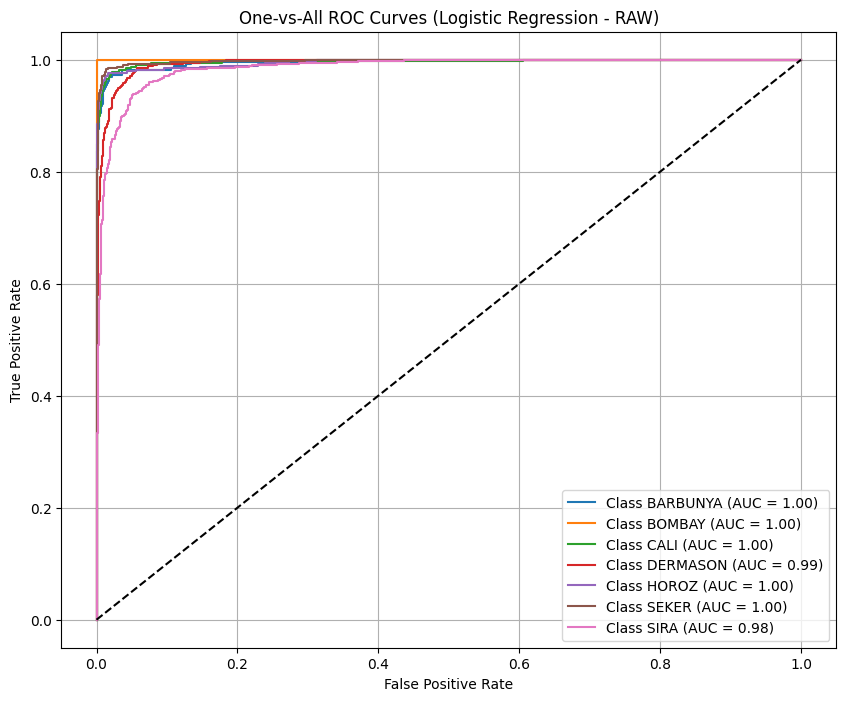

⚙️  Model: Decision Tree

🔁 Outer Fold 1

🔁 Outer Fold 2

🔁 Outer Fold 3

🔁 Outer Fold 4

🔁 Outer Fold 5


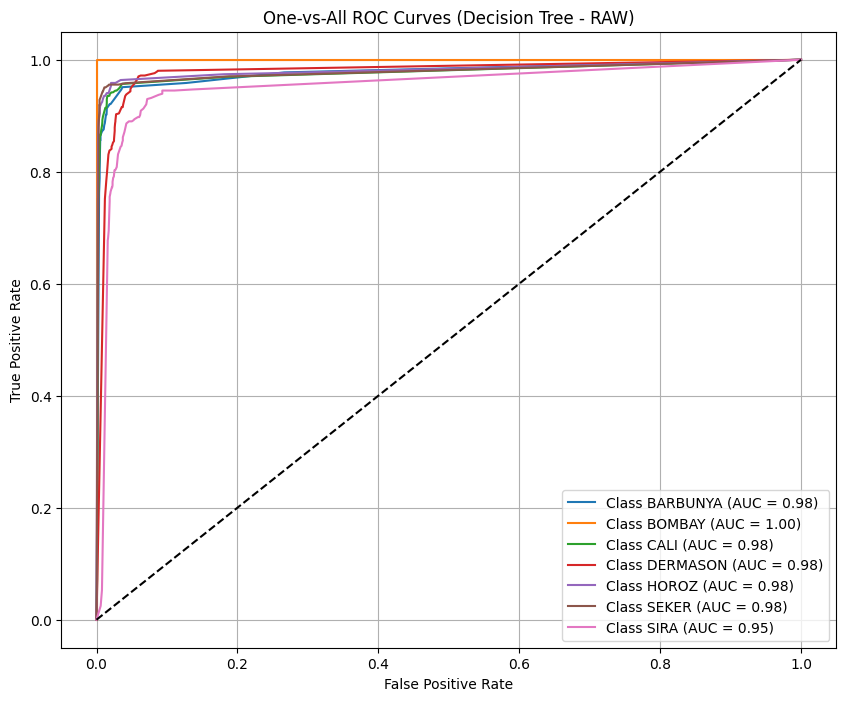

⚙️  Model: Random Forest

🔁 Outer Fold 1

🔁 Outer Fold 2

🔁 Outer Fold 3

🔁 Outer Fold 4

🔁 Outer Fold 5


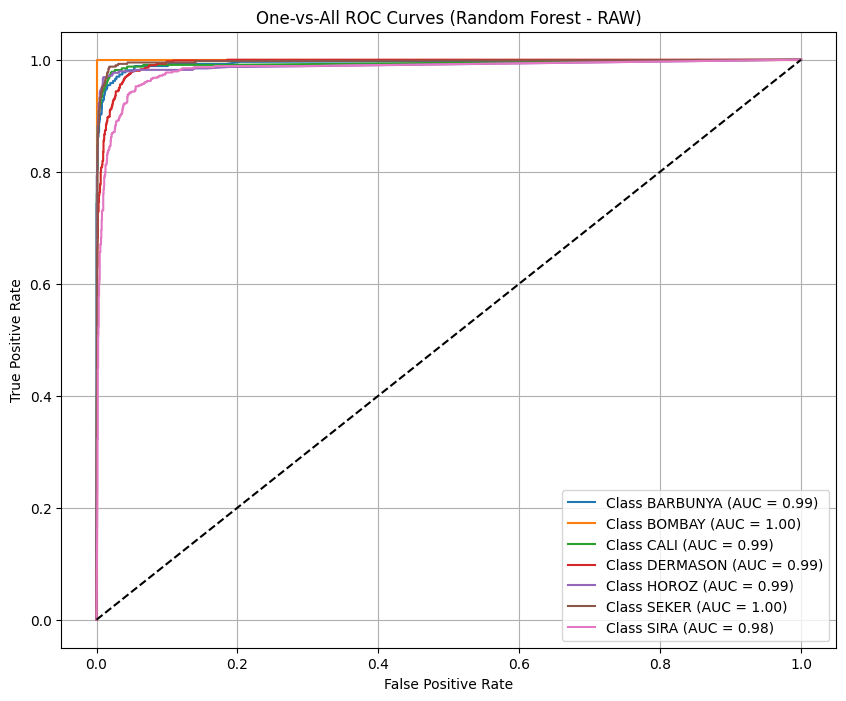

⚙️  Model: XGBoost

🔁 Outer Fold 1


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:00:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Outer Fold 2


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:02:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Outer Fold 3


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:04:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Outer Fold 4


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:06:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Outer Fold 5


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:08:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


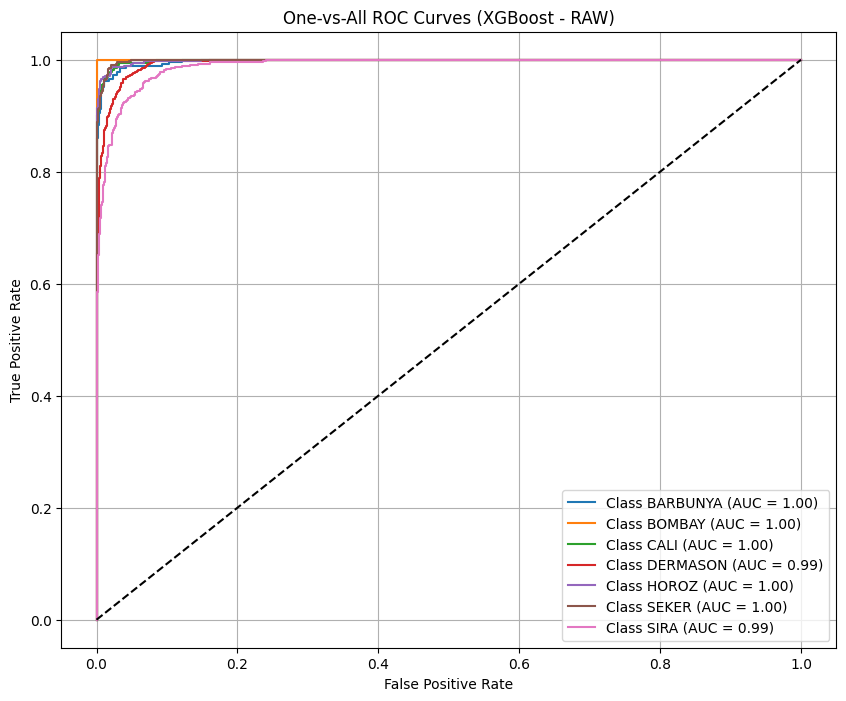

⚙️  Model: Naive Bayes

🔁 Outer Fold 1

🔁 Outer Fold 2

🔁 Outer Fold 3

🔁 Outer Fold 4

🔁 Outer Fold 5


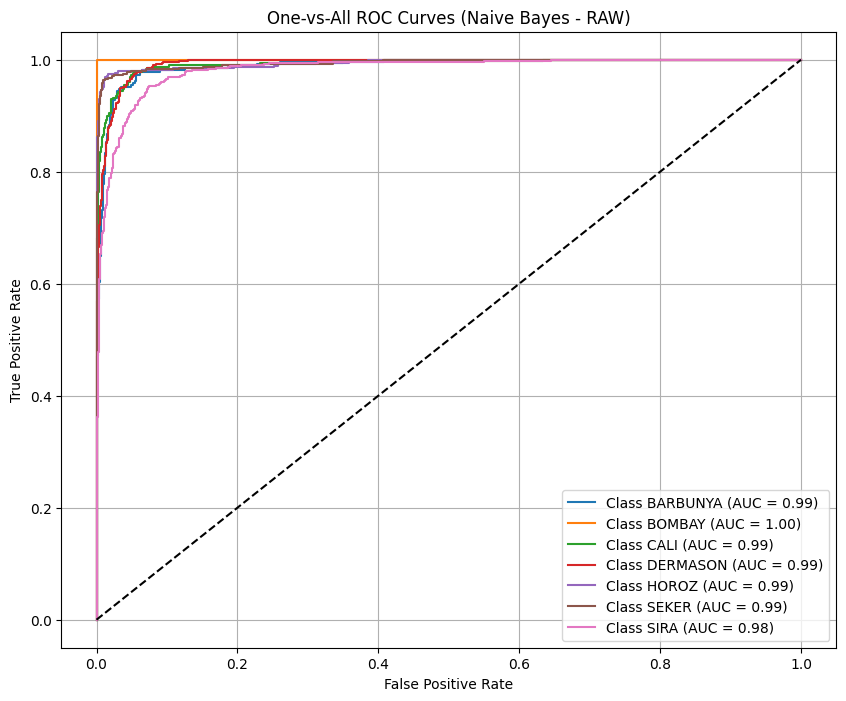


📊 Dataset: PCA
⚙️  Model: Logistic Regression

🔁 Outer Fold 1

🔁 Outer Fold 2

🔁 Outer Fold 3

🔁 Outer Fold 4

🔁 Outer Fold 5


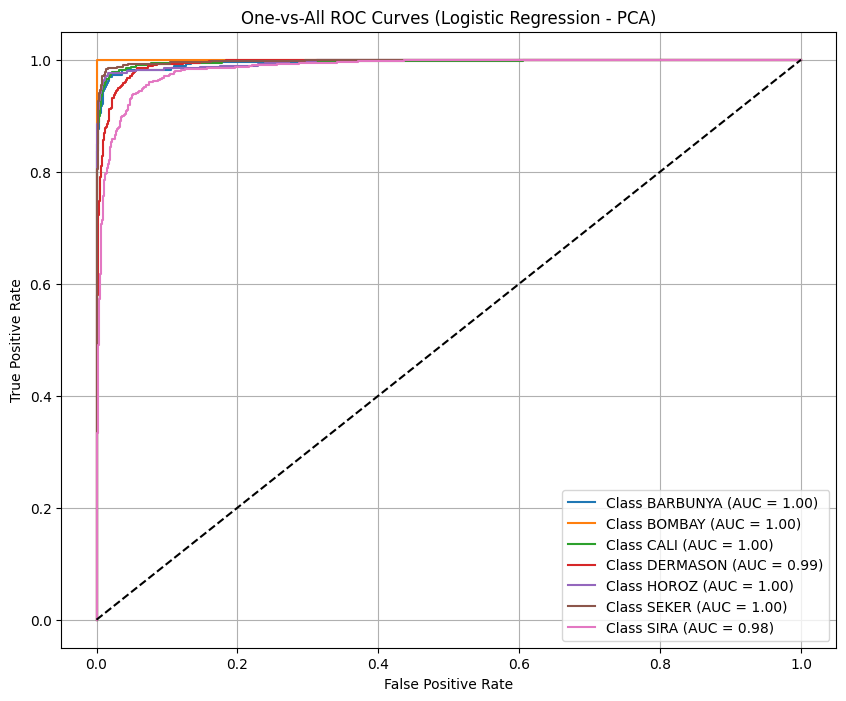

⚙️  Model: Decision Tree

🔁 Outer Fold 1

🔁 Outer Fold 2

🔁 Outer Fold 3

🔁 Outer Fold 4

🔁 Outer Fold 5


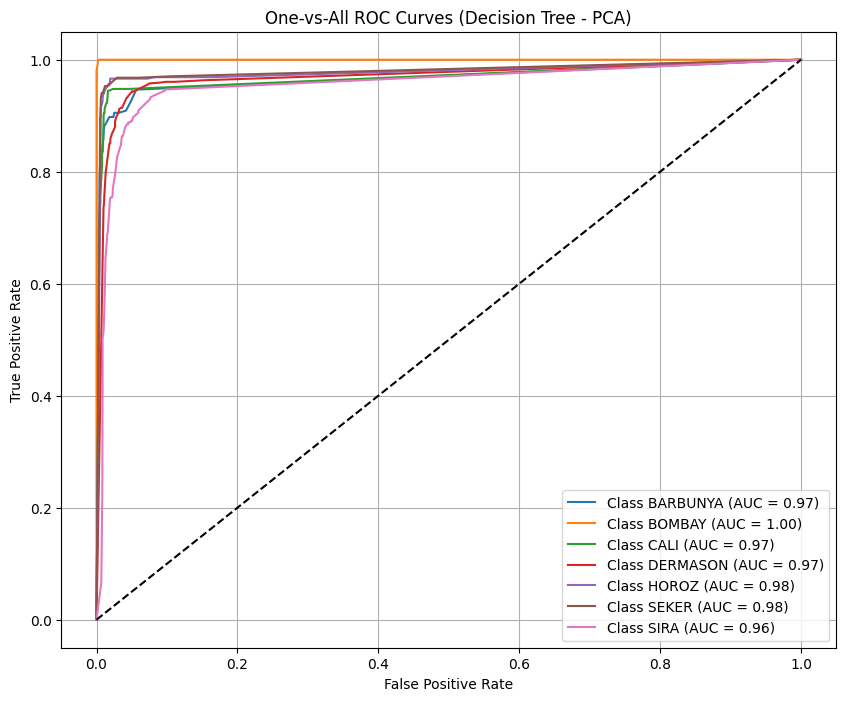

⚙️  Model: Random Forest

🔁 Outer Fold 1

🔁 Outer Fold 2

🔁 Outer Fold 3

🔁 Outer Fold 4

🔁 Outer Fold 5


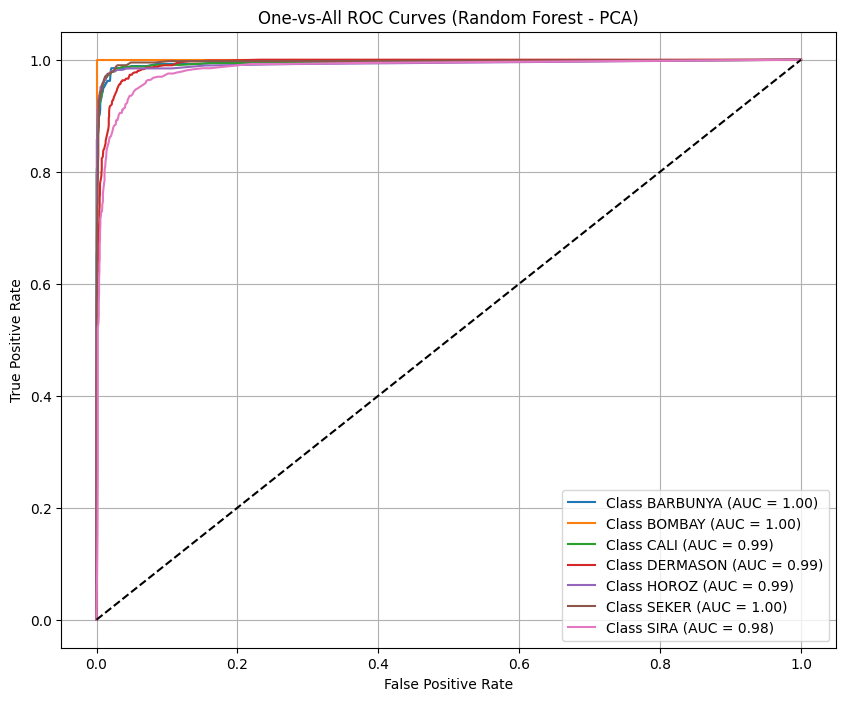

⚙️  Model: XGBoost

🔁 Outer Fold 1


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:18:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Outer Fold 2


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:20:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Outer Fold 3


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:23:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Outer Fold 4


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:25:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Outer Fold 5


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


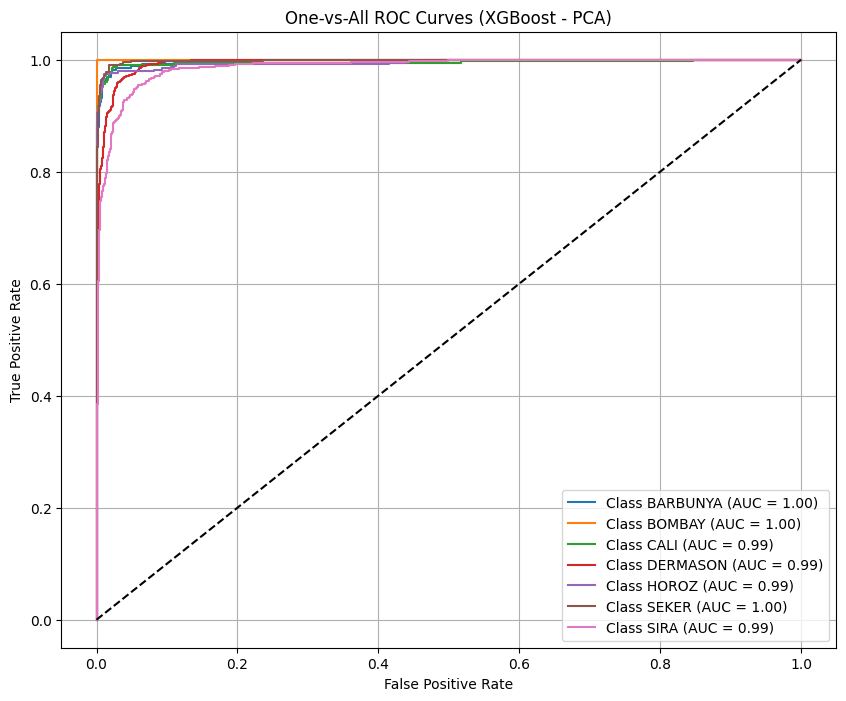

⚙️  Model: Naive Bayes

🔁 Outer Fold 1

🔁 Outer Fold 2

🔁 Outer Fold 3

🔁 Outer Fold 4

🔁 Outer Fold 5


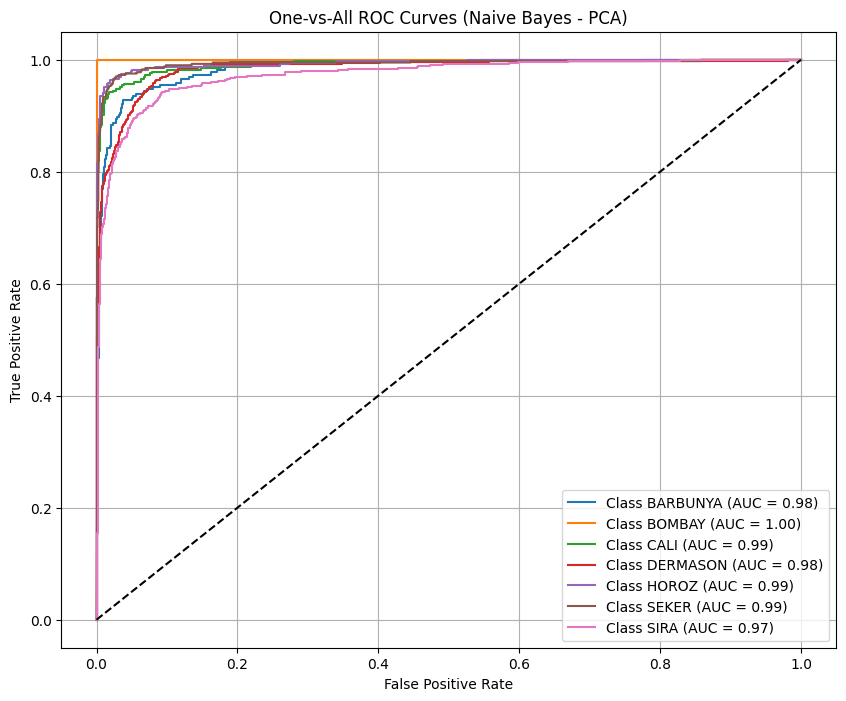


📊 Dataset: LDA
⚙️  Model: Logistic Regression

🔁 Outer Fold 1

🔁 Outer Fold 2

🔁 Outer Fold 3

🔁 Outer Fold 4

🔁 Outer Fold 5


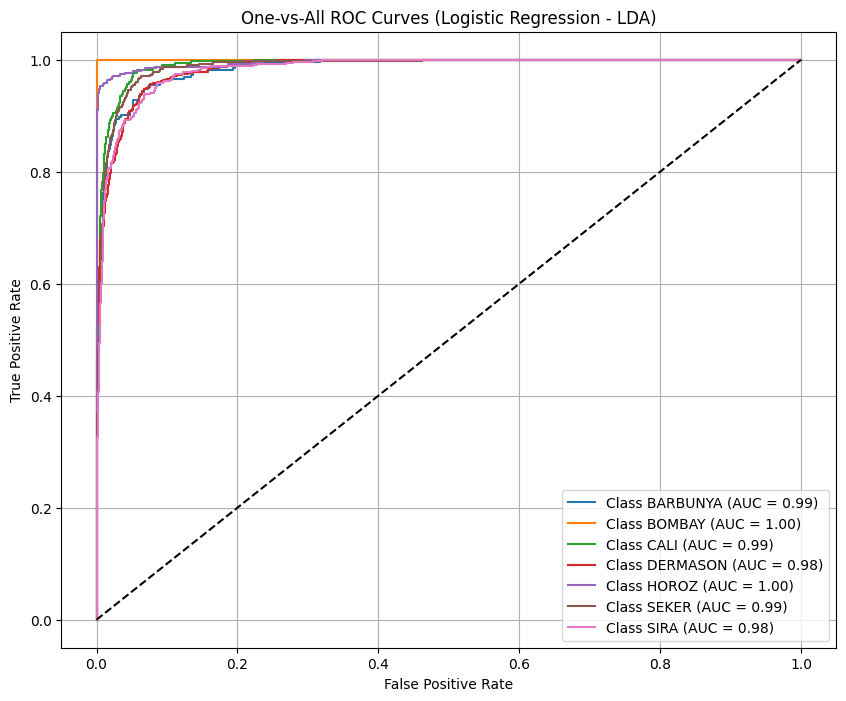

⚙️  Model: Decision Tree

🔁 Outer Fold 1

🔁 Outer Fold 2

🔁 Outer Fold 3

🔁 Outer Fold 4

🔁 Outer Fold 5


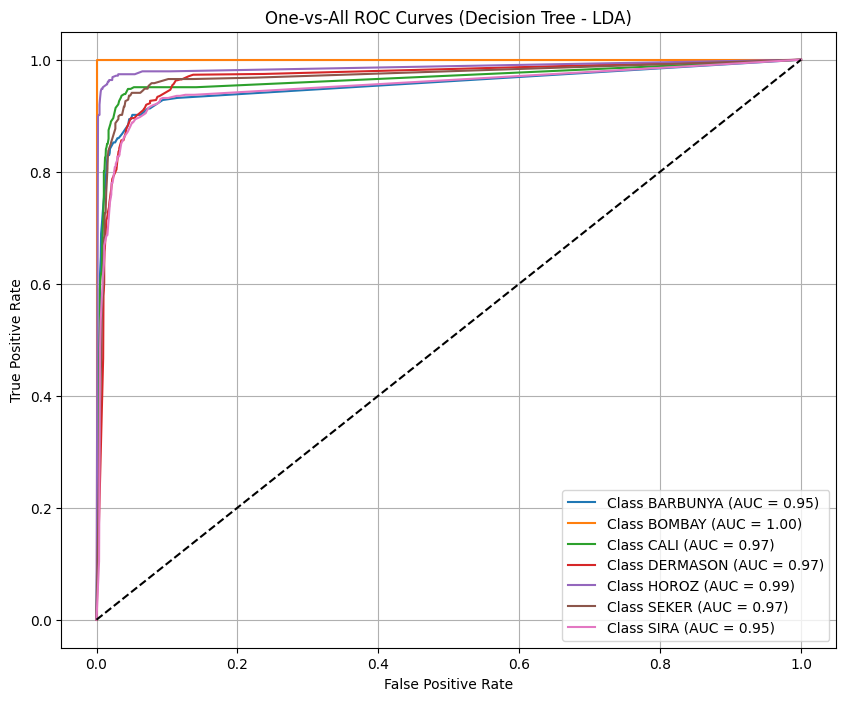

⚙️  Model: Random Forest

🔁 Outer Fold 1

🔁 Outer Fold 2

🔁 Outer Fold 3

🔁 Outer Fold 4

🔁 Outer Fold 5


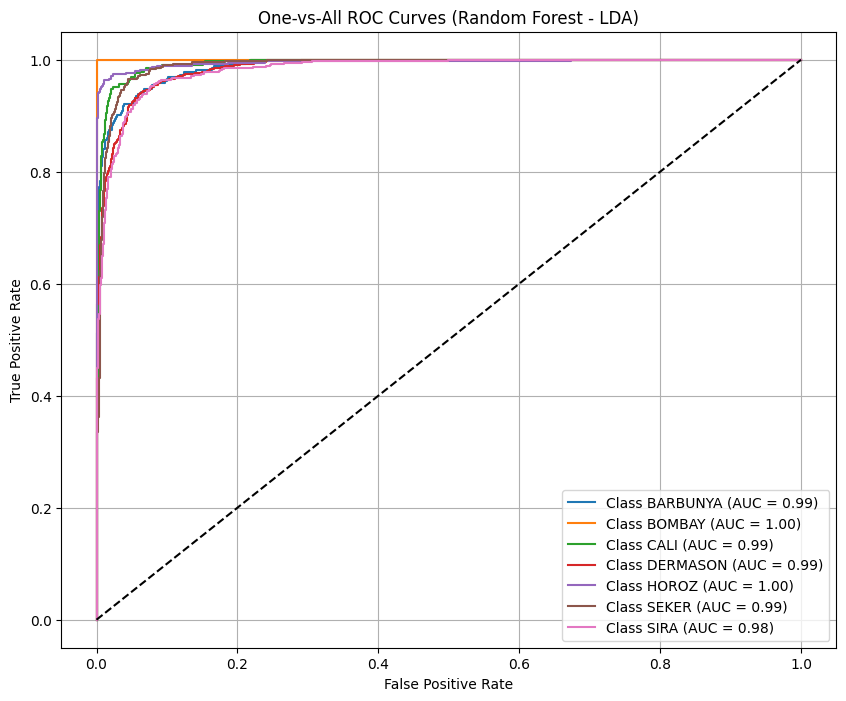

⚙️  Model: XGBoost

🔁 Outer Fold 1


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Outer Fold 2


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:32:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Outer Fold 3


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:33:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Outer Fold 4


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:34:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Outer Fold 5


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:35:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


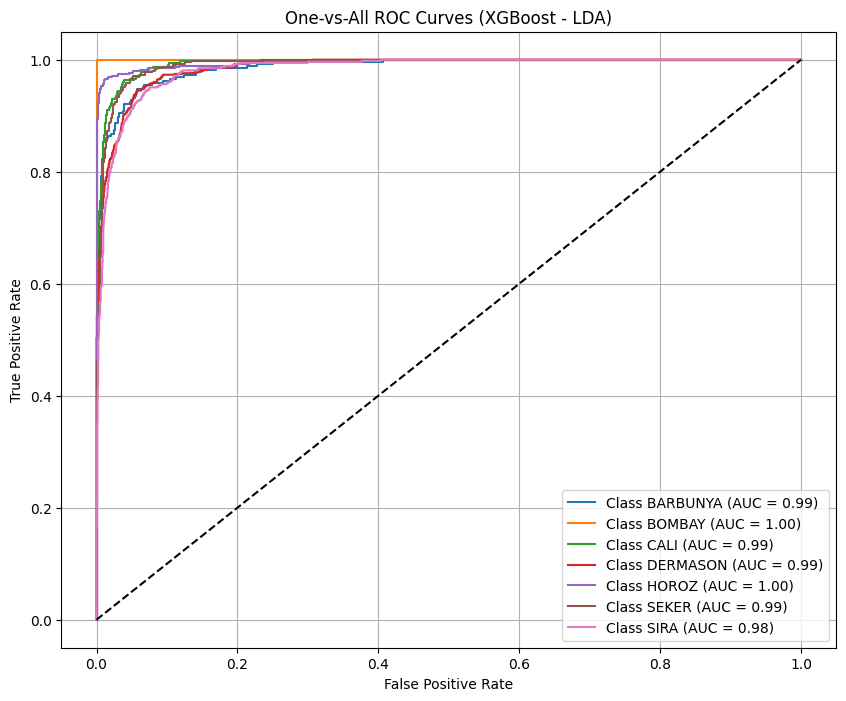

⚙️  Model: Naive Bayes

🔁 Outer Fold 1

🔁 Outer Fold 2

🔁 Outer Fold 3

🔁 Outer Fold 4

🔁 Outer Fold 5


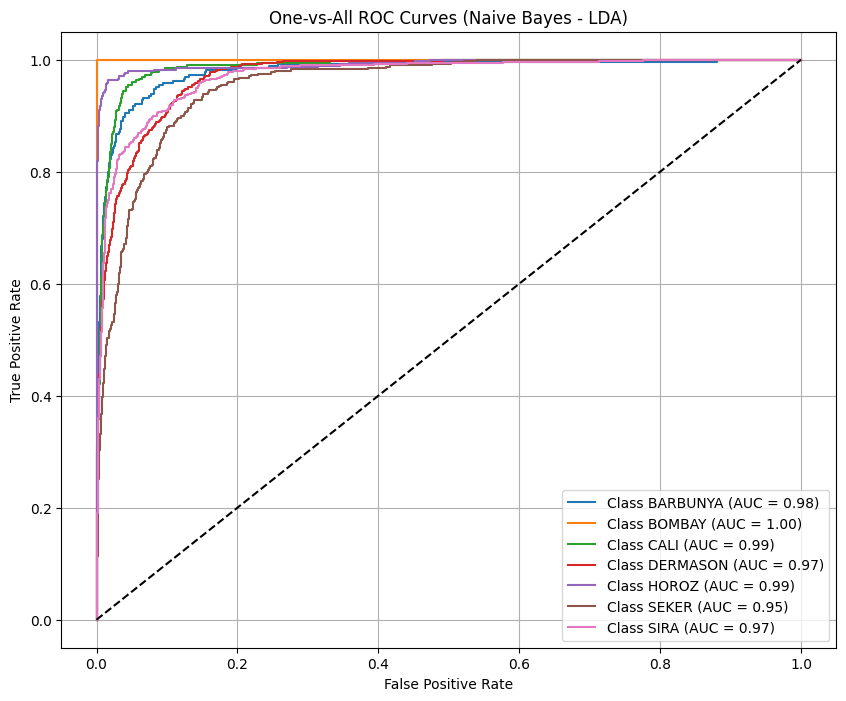

In [36]:
# ===============================================
# Plot ROC Curves for Best Models
# ===============================================

for dataset_name, (X_data, y_data) in datasets.items():
    print(f"\n📊 Dataset: {dataset_name}")

    for model_name, (model_instance, param_grid) in models.items():
        print(f"⚙️  Model: {model_name}")

        # Train using nested CV and get the best model
        _, (best_model, X_test, y_test) = nested_cv(
            X_data,
            y_data,
            model_instance,
            param_grid,
            return_best_model=True
        )

        n_classes = len(np.unique(y_data))
        class_names = label_encoder.classes_

        plot_roc_curves(
            best_model,
            X_test,
            y_test,
            n_classes,
            class_names,
            title_suffix=f"({model_name} - {dataset_name})"
        )